<a href="https://colab.research.google.com/github/Ira-Sharma/Image_Captioning_Tensorflow_Flickr8K/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting the Flickr8K dataset from Kaggle

In [ ]:
 ! pip install -q kaggle

In [ ]:
 from google.colab import files

In [ ]:
files.upload() #upload kaggle json file

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                           7KB  2022-06-15 08:59:12          10379        333  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)     6MB  2022-06-22 12:51:18           3427        127  1.0              
zusmani/petrolgas-prices-worldwide                        Petrol/Gas Prices Worldwide                        10KB  2022-06-24 01:25:33           2840        124  1.0              
ramjasmaurya/1-gb-internet-price                          Internet Prices around 200+ countries in 2

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:28<00:00, 39.6MB/s]
100% 1.04G/1.04G [00:28<00:00, 38.7MB/s]


In [ ]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

Importing all the libraries required

In [ ]:
import os
import pickle
import numpy as np
from nltk import FreqDist
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

Loading the VGG16 model

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
import os
wd=os.getcwd()
print(wd)

/content


In [ ]:
WORKING_DIR = '/content'

Using VGG16 for feature extraction

In [ ]:
# extract features from image
features = {}
directory = os.path.join(WORKING_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))# store features in pickle

In [ ]:
# load features from pickle
with open('/content/drive/MyDrive/features.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(WORKING_DIR, 'captions.txt'), 'r') as f:# getting the captions from the dataset
    next(f)
    captions_doc = f.read()

Mapping of Image to Captions

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping.keys())

8091

In [ ]:
mapping.values()

In [ ]:
# creating corpus
corpus = ""
for ec in mapping.values():
    for el in ec:
        corpus += " "+el

In [ ]:
total_words = corpus.split()
vocabulary = set(total_words)
print("The size of vocabulary is {}".format(len(vocabulary)))

The size of vocabulary is 9861


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Creating frequency distribution of words

In [ ]:
# creating frequency distribution of words
freq_dist = FreqDist(total_words)
sorted_freq=freq_dist.most_common(len(vocabulary))# in ascending order
sorted_df=pd.DataFrame(sorted_freq, columns=["Word","Frequency"])# creating a dataframe of the frequency distribution of words in ascending order
sorted_df

,Word,Frequency
0,a,40271
1,.,34212
2,A,21481
3,in,18961
4,the,15328
...,...,...
9856,spaniels,1
9857,weight,1
9858,majestically,1
9859,scrolled,1


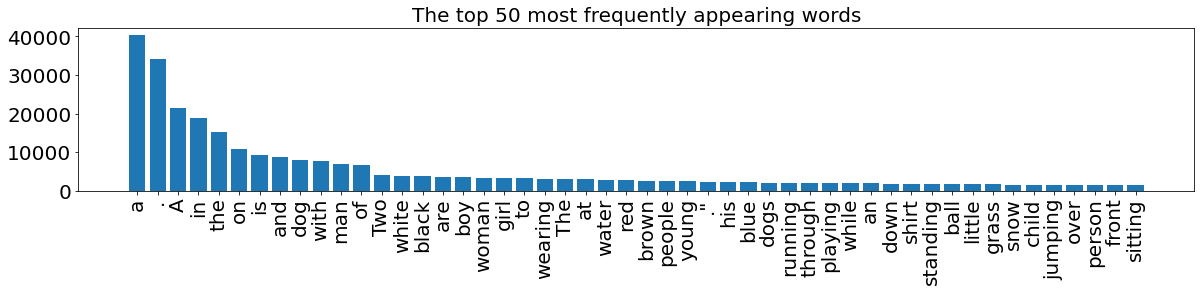

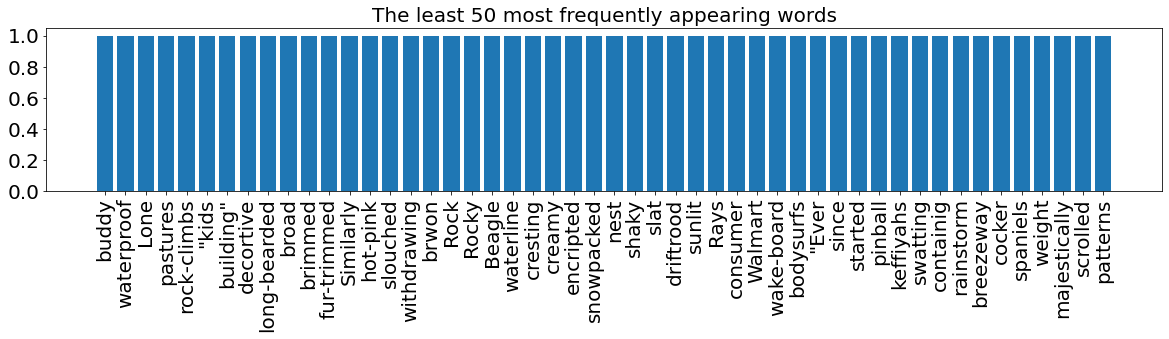

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["Frequency"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["Word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(sorted_df.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(sorted_df.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Preprocessing the captions text

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocessing 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# Preprocessing
clean(mapping)

In [ ]:
#after preprocessing
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# creating corpus after cleaning
corpus = ""
for ec in mapping.values():
    for el in ec:
        corpus += " "+el

In [ ]:
total_words = corpus.split()
vocabulary = set(total_words)
print("The new size of vocabulary is {}".format(len(vocabulary)))

The new size of vocabulary is 9149


In [ ]:
# creating frequency distribution of words after cleaning
freq_dist = FreqDist(total_words)
sorted_freq=freq_dist.most_common(len(vocabulary))# in ascending order
sorted_df=pd.DataFrame(sorted_freq, columns=["Word","Frequency"])# creating a dataframe of the frequency distribution of words in ascending order
sorted_df

,Word,Frequency
0,startseq,40455
1,endseq,40455
2,in,18965
3,the,18249
4,on,10732
...,...,...
9144,spaniels,1
9145,weight,1
9146,majestically,1
9147,scrolled,1


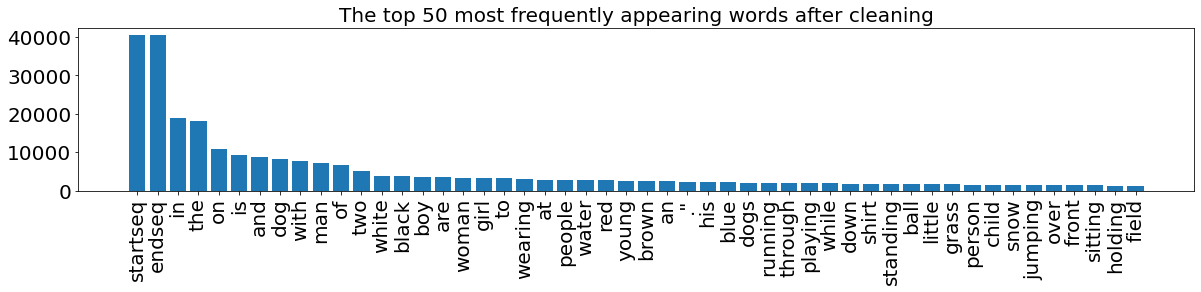

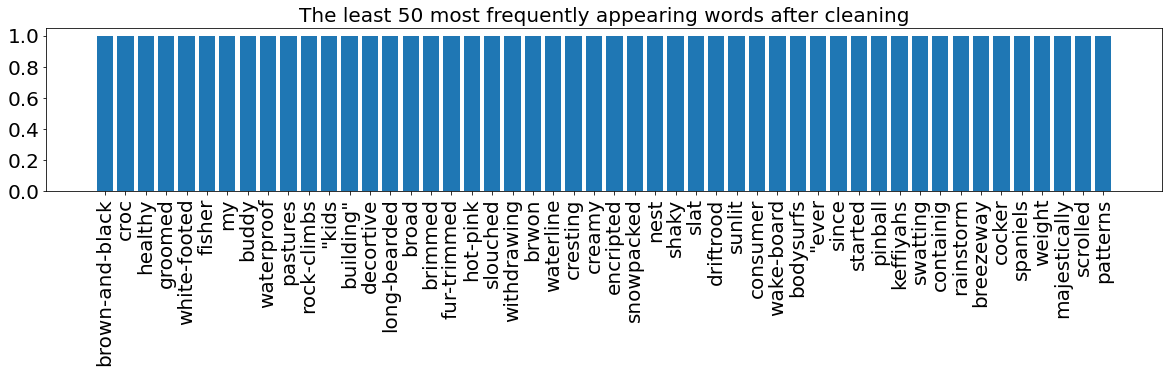

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["Frequency"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["Word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(sorted_df.iloc[:topn,:],
        title="The top 50 most frequently appearing words after cleaning")
plthist(sorted_df.iloc[-topn:,:],
        title="The least 50 most frequently appearing words after cleaning")

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Changing character vector to integer vector using Tokenizer

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

Model Creation

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_len, vocab_size, batch_size):
    x1, x2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            cptns = mapping[key]
            for cptn in cptns:
                seq = tokenizer.texts_to_sequences([cptn])[0]
                for i in range(len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                
            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield [x1,x2], y
                x1, x2, y = [], [], []
                n = 0 

In [ ]:
# encoder model
# image feature layers
input1 = Input(shape=(4096,))
l1 = Dropout(0.1)(input1)
l2 = Dense(1024, activation='relu')(l1)
# sequence feature layers
input2 = Input(shape=(max_length,))
l3 = Embedding(vocab_size, 256, mask_zero=True)(input2)
l4 = Dropout(0.1)(l3)
l5 = LSTM(1024)(l4)
# decoder model
dcdr1 = add([l2,l5])
dcdr2 = Dense(1024, activation='relu')(dcdr1)
output = Dense(vocab_size, activation = 'softmax')(dcdr2)

model = Model(inputs=[input1,input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

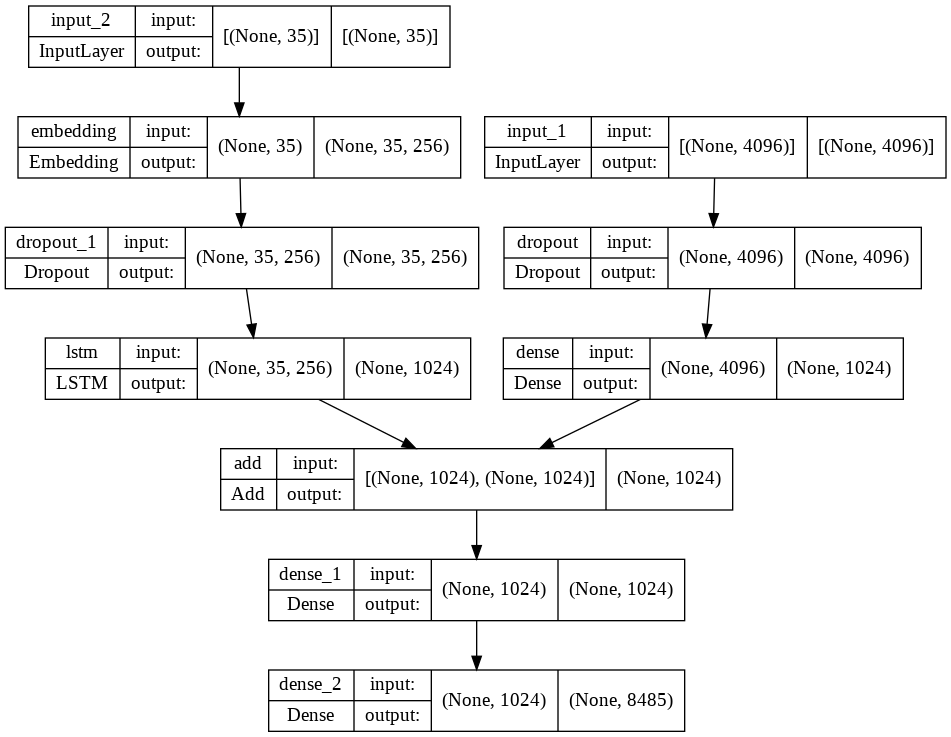

In [ ]:
# plot the model
plot_model(model, show_shapes=True)

Training the model

In [ ]:
def train(data, epochs, batch_size):
    steps = len(data) // batch_size
    for i in range(epochs):
        generator = data_generator(data, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


In [ ]:
#Splitting the data into train and test data
img_ids = list(mapping.keys())
train_data = img_ids[:int(len(img_ids) * 0.8)]
test_data = img_ids[int(len(img_ids) * 0.8):]
#Training the model on train data
train(train_data, epochs=10, batch_size=64)

101/101 [==============================] - 135s 1s/step - loss: 2.1014


In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "model10epoch.h5")


In [ ]:
from tensorflow.keras.models import load_model
 # load model
model = load_model('model10epoch.h5')

Text(0.5, 1.0, 'steps vs loss for 15 epochs')

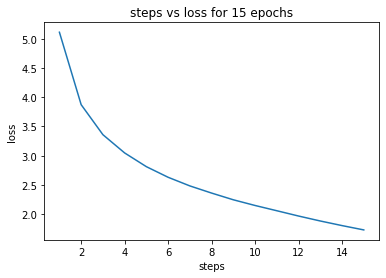

In [ ]:
steps=[]
for i in range(1,16):
  steps.append(i)
loss=[5.1108,3.8723,3.3591,3.0470,2.8121,2.6307,2.4831,2.3606,2.2458,2.1484,2.0586,1.9680,1.8832,1.8045,1.7306]
plt.plot(steps,loss)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('steps vs loss for 15 epochs')


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Generating caption for the images

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
features['3618525295_d32d634b2e']

Testing the model and finding the BLEU score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
# validate with test data
actual, predicted, bleu = list(), list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    bleu.append(sentence_bleu(actual_captions, y_pred, weights=(1.0, 0, 0, 0)))
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1619 [00:00<?, ?it/s]

BLEU-1: 0.527980
BLEU-2: 0.304843


In [ ]:
bleu

In [ ]:
test_data

Text(0.5, 1.0, 'Images and their corresponding Bleu Score for 10 epochs training model')

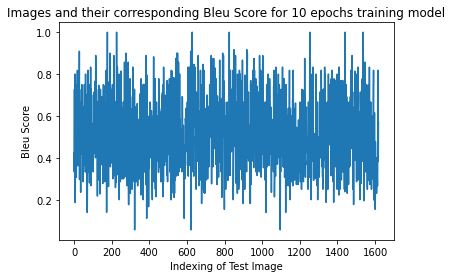

In [ ]:
x=[]
for i in range(0, len(test_data)):
  x.append(i)
plt.plot(x,bleu)
plt.xlabel('Indexing of Test Image')
plt.ylabel('Bleu Score')
plt.title('Images and their corresponding Bleu Score for 10 epochs training model')

Displaying the Image with the Predicted captions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(WORKING_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    actual=[caption.split() for caption in captions]
    predict=y_pred.split()
    b=sentence_bleu(actual, predict, weights=(1.0, 0, 0, 0))
    print("BLEU-1: %f" % b)
    if b<0.5:
      print("Bad Caption")
    elif b>0.5 and b<0.7:
      print("Not Bad Caption")
    else:
      print("Good Caption")
    plt.imshow(image)


---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play tug of war endseq
BLEU-1: 0.551561
Not Bad Caption


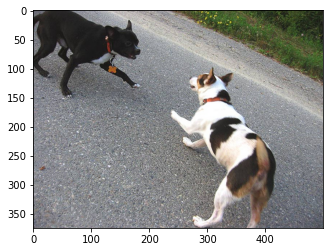

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")


---------------------Actual---------------------
startseq blue motorcycle and sidecar is being raced on wet track endseq
startseq man races in small vehicle while another man hangs off the back endseq
startseq racer in blue car towing man in black suit on the street endseq
startseq racing on wet road while man hangs on back endseq
startseq two people on blue motorcycle endseq
--------------------Predicted--------------------
startseq man on motorcycle is driving on track endseq
BLEU-1: 0.888889
Good Caption


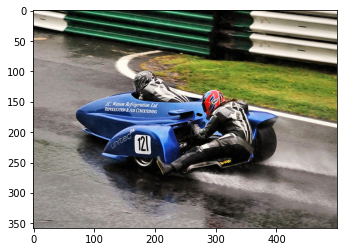

In [ ]:
generate_caption("3604314527_5077cd9d43.jpg")

---------------------Actual---------------------
startseq guy with sunglasses stands on skateboard in front of circle design wall endseq
startseq man is skateboarding on asphalt while the sun beams over wall endseq
startseq man on skateboard endseq
startseq "a young man skateboards in black shoes black pants and white top with sunglasses ." endseq
startseq skateboarder wearing shades in front of wall that looks like fishscales endseq
--------------------Predicted--------------------
startseq young girl in blue shirt in the middle of the camera in the middle of the middle of the middle of the girl in the middle of the girl in the middle of the girl
BLEU-1: 0.138889
Bad Caption


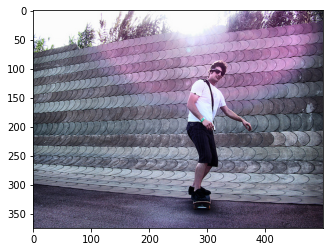

In [ ]:
generate_caption("3607969989_68cc411493.jpg")

---------------------Actual---------------------
startseq bmx racer comes down hill everything around him is blur endseq
startseq dirt biker rides down trail endseq
startseq man in blue is riding bicycle on track endseq
startseq mountain biker is giong down hill on his bike endseq
startseq mountain biker on blue mountain bike gets air time endseq
--------------------Predicted--------------------
startseq man rides dirt bike down hill endseq
BLEU-1: 1.000000
Good Caption


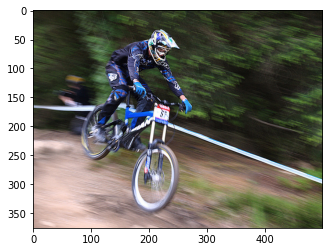

In [ ]:
generate_caption("3607489370_92683861f7.jpg")

---------------------Actual---------------------
startseq group of race horses run down track carrying jockeys endseq
startseq horse race endseq
startseq jockeys on horses during race endseq
startseq the horses race on the dirt track while their riders urge them on endseq
startseq "there are riders and horses in horse race going around track ." endseq
--------------------Predicted--------------------
startseq the bull is wearing black and black outfit endseq
BLEU-1: 0.361935
Bad Caption


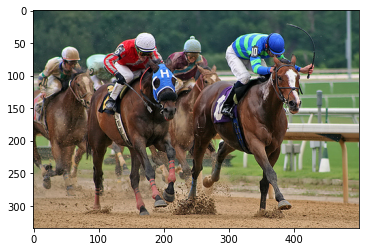

In [ ]:
generate_caption("3601569729_bf4bf82768.jpg")

---------------------Actual---------------------
startseq couple of dogs running through the water with trees in the background endseq
startseq two dogs are running through small pond endseq
startseq "two dogs play in river one is making splash ." endseq
startseq two dogs run through the water near trees endseq
startseq two dogs standing in lake endseq
--------------------Predicted--------------------
startseq dog running through the water endseq
BLEU-1: 0.857143
Good Caption


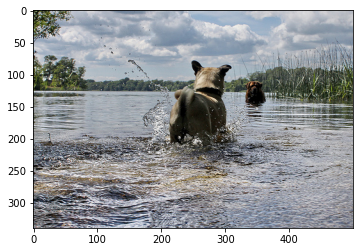

In [ ]:
generate_caption("3608752424_01a1cfd8a6.jpg")